<a href="https://colab.research.google.com/github/abstractguy/TSO_project/blob/master/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import pathlib
import numpy as np
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import mobilenet_v2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
data_dir = keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
flower_path = list(data_dir.glob('*roses*/*'))[0]
flower_path

PosixPath('/root/.keras/datasets/flower_photos/roses/2536282942_b5ca27577e.jpg')

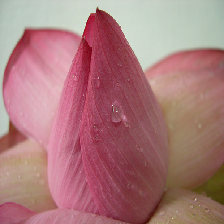

In [4]:
image.load_img(flower_path, target_size=(224, 224))

In [0]:
mobile = keras.applications.mobilenet_v2.MobileNetV2()

In [0]:
def prepare_image(file):
    img = image.load_img(file, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)

In [7]:
preprocessed_image = prepare_image(flower_path)
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n07753113', 'fig', 0.16768108),
  ('n04277352', 'spindle', 0.028070359),
  ('n03908714', 'pencil_sharpener', 0.025865411),
  ('n12144580', 'corn', 0.021213928),
  ('n04597913', 'wooden_spoon', 0.016775185)]]

In [8]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________